In [1]:
import pandas as pd
import numpy as np

In [2]:
# pd.read_excel('Data/Copie de 20210108_161349_end_product_export_administrator.xlsx', index_col=0)

### Load Piece Data

In [3]:
# le derniere rang est tout NaN (c'est le seul a enlever)
# on utilise la colonne "NG DF" comme index
#df_mtb = pd.read_excel('Data/20210105_MTBF vs MTBUR.xlsx', index_col=2).dropna(how='all').dropna(thresh=4)
df_mtb = pd.read_excel('Data/20210105_MTBF vs MTBUR.xlsx', dtype={'NG DF': str}).dropna(how='all').dropna(thresh=5)
df_mtb = df_mtb.rename(columns={'NG DF': 'part number'})
df_mtb = df_mtb.set_index('part number')

In [4]:
df_mtbur = df_mtb.drop(columns=['Index DF', 'REF FAB SIMAT', 'MTBF'])
df_mtbur = df_mtbur.groupby(['part number']).min()
#df_mtbur.loc['143025495'][0]
#df_mtbur.tail()
#df_mtbf = df_mtb.drop(columns=['Index DF', 'REF FAB SIMAT', 'MTBUR']) # TODO

df_mtbur

,Designation,MTBUR
part number,,
010092872,MECANISME CDE ANTENNE DA1203A,5638.040000
013964179,POMPE A HUILE PRINCIPALE_x000D_\n,828.791880
013964180,POMPE A HUILE SECOURS,829.000000
140400636,POMPE DE TRANSFERT_x000D_\n,1300.132024
143010908,FERRURE ATTACHE AVANT_x000D_\n,5638.040000
...,...,...
145754555,BLOC HYD PA_x000D_\n,285.848628
145828816,CALCULATEUR AMC_x000D_\n,411.576920
195635296,POSTE CDE EDU COPILOTE,619.056792


### Load Helicop Data

In [5]:
# only store time and part number and value (hours of use)
helico1 = pd.read_excel('Data/end_product_EPR0000031_at_20210107.xlsx', sheet_name='life records')[['part number', 'value']]
helico1 = helico1.rename(columns={'value':'use'})
helico1

,part number,use
0,010092872,503.2
1,013964179,1025.4
2,013964180,1025.4
3,140400636,580.5
4,143010908,503.2
...,...,...
188,195635296,1025.4
189,195635297,1025.4
190,999839550,882.8
191,999839550,503.2


### Check pieces not found in helico

In [6]:
# now we cross mtbur
#result = pd.merge(df_mtbur, helico1, right_on='part number', left_index=True)
notfound=0

for index, row in helico1.iterrows():
    if row['part number'] not in df_mtbur.index:
        print(row['part number'], 'not found')
        notfound=notfound+1
    #print(row['part number'], row['use'], 'h', 'mtbur:', df_mtbur.loc[row['part number']][1])
if notfound:
  print('pieces not found:', notfound)
    

HM/COUGAR/AS532UL not found
pieces not found: 1


### Make dataframe with all info for each helico piece

In [7]:
dftemp = pd.DataFrame({'remaining_time':[], 'mtbur':[], 'piece':[]})

for index, row in helico1.iterrows():
    if row['part number'] in df_mtbur.index:
        #print('m:',df_mtbur.loc[row['part number']])
        mtbur = df_mtbur.loc[row['part number']][1]
        piece = df_mtbur.loc[row['part number']][0].strip()

        #print(type(mtbur), mtbur)
        #df2 = pd.DataFrame({'resting_time':row['use'], 'mtbur':mtbur})
        #dftemp.append(df2)
        dftemp = dftemp.append({'resting_time':mtbur-row['use'], 'mtbur':mtbur, 'piece':piece}, ignore_index=True)
    else:
        print('WARNING:', row['part number'], 'not found')
        dftemp = dftemp.append({'resting_time':np.nan,'mtbur':np.nan}, ignore_index=True)
        
helico_state = pd.concat([helico1, dftemp], axis=1)
neg = helico_state['resting_time'].lt(0)
#helico_state[neg]

In [8]:
helico_state

,part number,use,resting_time,mtbur,piece
0,010092872,503.2,5134.840000,5638.040000,MECANISME CDE ANTENNE DA1203A
1,013964179,1025.4,-196.608120,828.791880,POMPE A HUILE PRINCIPALE_x000D_
2,013964180,1025.4,-196.400000,829.000000,POMPE A HUILE SECOURS
3,140400636,580.5,719.632024,1300.132024,POMPE DE TRANSFERT_x000D_
4,143010908,503.2,5134.840000,5638.040000,FERRURE ATTACHE AVANT_x000D_
...,...,...,...,...,...
188,195635296,1025.4,-406.343208,619.056792,POSTE CDE EDU COPILOTE
189,195635297,1025.4,-406.343208,619.056792,POSTE CDE EDU PILOTE
190,999839550,882.8,4783.430200,5666.230200,EXTINCTEUR CABINE (SOUTE)_x000D_
191,999839550,503.2,5163.030200,5666.230200,EXTINCTEUR CABINE (SOUTE)_x000D_


### Some conclusions

In [9]:
nn = len(helico_state[neg])
print('Overused pieces (use time surpassed MTBUR): {} pieces ({:.2f}%)'.format(nn, nn/len(helico1)*100))

Overused pieces (use time surpassed MTBUR): 73 pieces (37.82%)


### NN

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical

In [11]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

In [12]:
piece_name = df_mtbur.iloc[0][0]
mtbur_piece = df_mtbur.iloc[0][1]

print(piece_name)
print(mtbur_piece)

MECANISME CDE ANTENNE DA1203A
5638.04


In [13]:
#pieces = mtbur_piece + (0.1 * mtbur_piece) * np.random.randn(750, )
#pieces = np.random.randint(0, mtbur_piece + mtbur_piece * 0.05, 1000)

In [14]:
def generate_data(mtbf, N):
    l = 1/mtbf

    times = np.random.sample(N) * (mtbf*3)
    probs = np.exp(-l * times) # proba de survie
    y = np.random.rand(len(probs)) < probs
    # si rand < prob, y = True (la pièce est cassée)
    return pd.DataFrame(list(zip(times, probs, y)), columns=['flight_time', 'survival_prob', 'state'])

In [15]:
df = generate_data(mtbur_piece, 100000)

In [16]:
df

,flight_time,survival_prob,state
0,522.723319,0.911454,True
1,6833.574791,0.297587,False
2,8444.638153,0.223622,False
3,6610.093663,0.309620,False
4,2829.640204,0.605389,True
...,...,...,...
99995,4008.541449,0.491162,False
99996,9609.910691,0.181867,False
99997,14778.003747,0.072721,False
99998,6563.393832,0.312195,False


In [17]:
x = df.drop(columns=['state']).to_numpy()
y = df['state'].to_numpy()

In [18]:
x = normalize(x)
y = to_categorical(y, num_classes=2)
#y = normalize(y)

#y = y.reshape(-1)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [20]:
model = Sequential()

model.add(Dense(16, activation="relu", input_shape=(2, )))
model.add(Dense(16, activation="relu"))

#model.add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))

#model.add(Dropout(0.2))
          
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(
    optimizer=Adam(learning_rate=1e-2), loss="binary_crossentropy", metrics=["accuracy"]
)

# Launch the training of the network on the data
history = model.fit(x_train, y_train, verbose=1, epochs=30, batch_size=64, validation_split=0.2)

Epoch 1/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6254 - accuracy: 0.6829 - val_loss: 0.6225 - val_accuracy: 0.6849
Epoch 2/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6220 - accuracy: 0.6857 - val_loss: 0.6159 - val_accuracy: 0.6905
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6133 - accuracy: 0.6950 - val_loss: 0.5894 - val_accuracy: 0.7097
Epoch 4/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5839 - accuracy: 0.7208 - val_loss: 0.5762 - val_accuracy: 0.7356
Epoch 5/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5590 - accuracy: 0.7449 - val_loss: 0.5595 - val_accuracy: 0.7452
Epoch 6/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5641 - accuracy: 0.7423 - val_loss: 0.5801 - val_accuracy: 0.7312
Epoch 7/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5445 - accuracy: 0.7564 - val_loss: 0.5065 - val_accuracy:

In [22]:
loss, acc = model.evaluate(x_train, y_train, verbose=0)

print(f"Training loss: {loss:.05f}")
print(f"Training accuracy: {acc:.05f}")

Training loss: 0.47698
Training accuracy: 0.78761


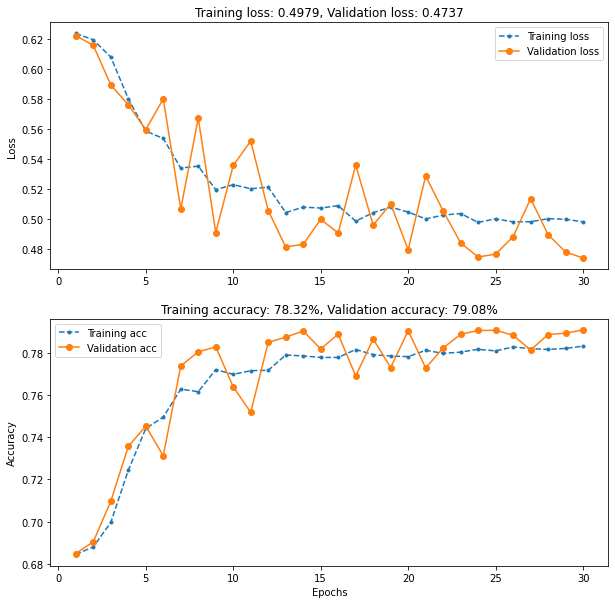

In [23]:
plot_loss_acc(history)